In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product
from perlin_numpy import generate_perlin_noise_2d
from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [78]:
np.random.seed(0)

xy_range = ((-1, 1), (-1, 1))

m = 5
n = 100

percentile = 50

iterations = 20

laplace_alpha = 0

In [79]:
X = np.arange(*xy_range[0], ((xy_range[0][1] - xy_range[0][0]) / 100))
Y = np.arange(*xy_range[1], ((xy_range[1][1] - xy_range[1][0]) / 100))
X, Y = np.meshgrid(X, Y)
Z = generate_perlin_noise_2d((100, 100), (2, 2))

In [80]:
z_range = (np.floor(np.min(Z)) - 1, np.ceil(np.max(Z)) + 1)

In [81]:
ran_err = lambda n, x: np.random.normal(0, x, n)
sys_err = lambda n, z: z * np.random.normal(2, 0.05, n)

In [82]:
df = pd.DataFrame(np.random.randint(100, size=(m, 2)))

df.columns = ["i", "j"]

df["x"] = X[0, df["i"]]
df["y"] = Y[df["j"], 0]
df["z"] = Z[df["i"], df["j"]] + ran_err(m, 0.05)

for idx in range(1, iterations + 1):
    krnl = RBF(length_scale=1)
    model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

    tmp_df = pd.DataFrame(np.random.randint(100, size=(n, 2)))

    tmp_df.columns = ["i", "j"]

    tmp_df["x"] = X[0, tmp_df["i"]]
    tmp_df["y"] = Y[tmp_df["j"], 0]
    tmp_df["z"] = Z[tmp_df["i"], tmp_df["j"]] + ran_err(n, 0.05) + sys_err(n, Z[tmp_df["i"], tmp_df["j"]])

    model.fit(tmp_df[["x", "y"]], tmp_df["z"])

    pred = model.predict(tmp_df[["x", "y"]])

    z = griddata((tmp_df["x"], tmp_df["y"]), pred, (X.T, Y.T), method="linear", fill_value=z_range[0])

    tmp_df = pd.DataFrame(list(product(range(100), range(100))), columns=["i", "j"])

    tmp_df["x"] = X[0, tmp_df["i"]]
    tmp_df["y"] = Y[tmp_df["j"], 0]
    tmp_df["z"] = Z[tmp_df["i"], tmp_df["j"]] + ran_err(10000, 0.05)

    diff = Z[tmp_df["i"], tmp_df["j"]] - z[tmp_df["i"], tmp_df["j"]]

    p = np.where(diff > 0, diff, 0) + laplace_alpha

    p = np.where(p > np.percentile(p, percentile), p, 0)

    p /= p.sum()

    tmp_df = tmp_df.loc[np.random.choice(tmp_df.index, size=m, p=p, replace=False)]

    df = pd.concat([df, tmp_df], ignore_index=True)

krnl = RBF(length_scale=1)
model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

model.fit(df[["x", "y"]], df["z"])

c:\Program Files\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: Converge

GaussianProcessRegressor(alpha=0.001, kernel=RBF(length_scale=1),
                         random_state=3)

0.3225921517226512 at (94, 15)
0.5763531667019053 at (40, 75)
RMSE: 0.2793786238232639


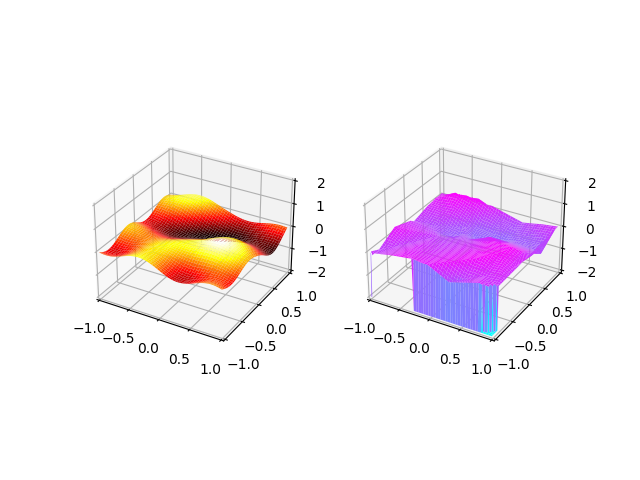

In [83]:
%matplotlib widget

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})

pred = model.predict(df[["x", "y"]])

z = griddata((df["x"], df["y"]), pred, (X.T, Y.T), method="linear", fill_value=z_range[0])

print(Z[np.unravel_index(z.argmax(), z.shape)], "at", np.unravel_index(z.argmax(), z.shape))
print(Z.max(), "at", np.unravel_index(Z.argmax(), Z.shape))

df = pd.DataFrame(list(product(range(100), range(100))), columns=["i", "j"])

df["x"] = X[0, df["i"]]
df["y"] = Y[df["j"], 0]
df["z"] = Z[df["i"], df["j"]]

pred = model.predict(df[["x", "y"]])

sum = np.sum((pred - df["z"])**2)
rmse = np.sqrt(sum / len(df["z"]))

print("RMSE:", rmse)

axs[0].plot_surface(X, Y, Z, cmap="hot")
axs[1].plot_surface(X, Y, z, cmap="cool")

axs[0].set_xlim(*xy_range[0])
axs[0].set_ylim(*xy_range[1])
axs[0].set_zlim(*z_range)
axs[1].set_xlim(*xy_range[0])
axs[1].set_ylim(*xy_range[1])
axs[1].set_zlim(*z_range)

plt.show()